<div align='center'>
    <b><i><font size=6>Ejemplos</font></font></i><br></b>
    <i><font size=3>Redes Neuronales LSTM</font></i><br>
</div>

# Ejemplo con datos simulados

Cargamos algunas librerías necesarias. Donde esta LSTM

---



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import pandas as pd
#import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
#from tensorflow import keras
#
from tensorflow.keras.layers import Input, LSTM, Dense, GRU
from tensorflow.keras.models import Model
#
from tensorflow.keras.optimizers import Adam
#
from tensorflow.keras.utils import plot_model
#
from sklearn.preprocessing import MinMaxScaler
#
print("Versión de Tensorflow: ", tf.__version__)

Versión de Tensorflow:  2.3.0


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
#
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

Simulamos los datos

In [3]:
#
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
trend = .1
#
time = np.arange(0, 100, 0.1)
sin =  trend*time + np.sin(time) + np.random.normal(scale=0.5, size=len(time))

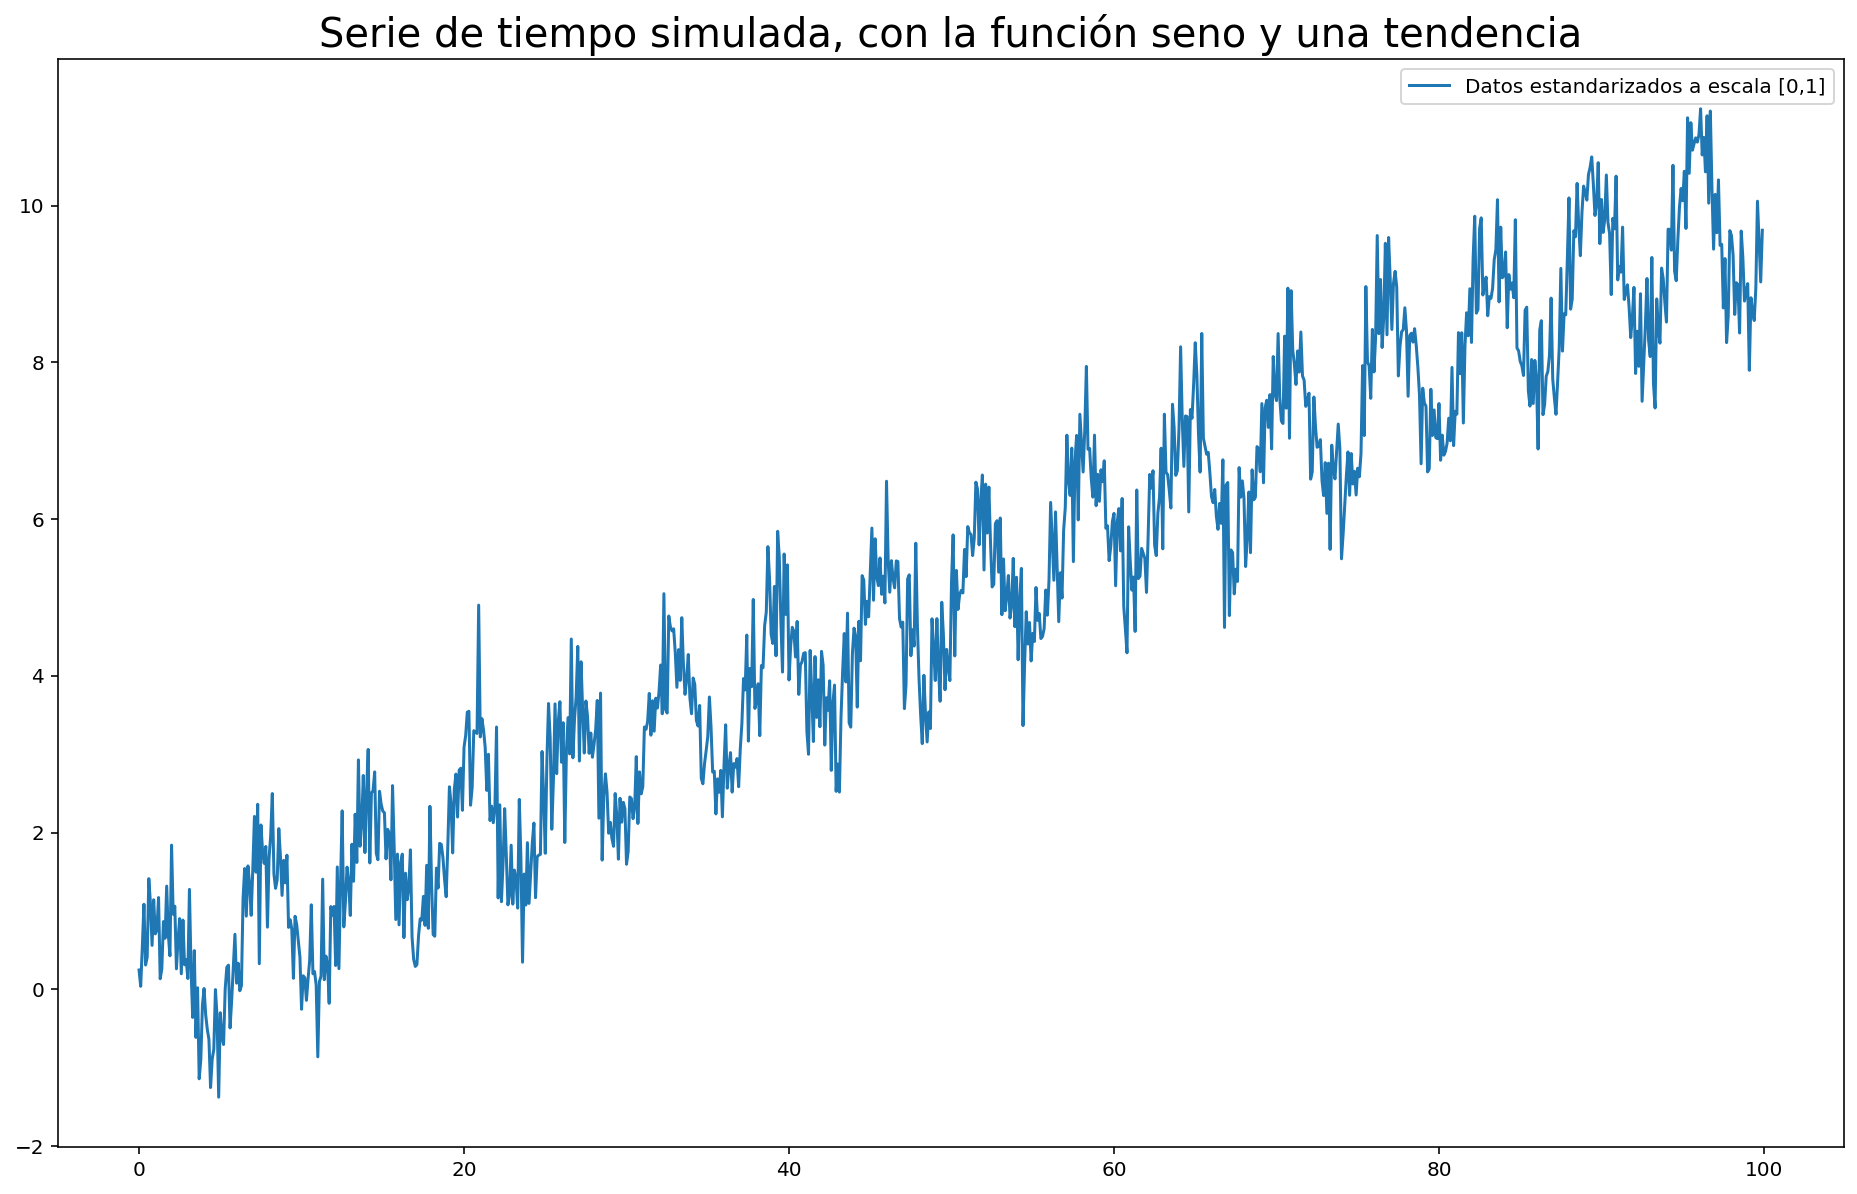

In [4]:
plt.plot(time, sin, label='Datos estandarizados a escala [0,1]');
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend();
plt.show()

Separación datos de entrenamiento y de validación

In [5]:
print('Número de datos', sin.shape[0])  

Número de datos 1000


## Preprocesamiento
Escalamos los datos

In [ ]:
#
df1 = pd.DataFrame(sin, index=time, columns=['serie'])
# crea el objeto  scaler y escala los datos como en clase
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1.values)
#
dataset = pd.DataFrame(scaled_data,index=df1.index, columns=['serie'])
#

Separamos los conjuntos de entrenamiento y test

In [ ]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(df1)]
#iloc separa por indices

len_train = len(train)
len_test = len(test)
print(len_train, len_test)
train.shape

800 200


(800, 1)

Plot para distinguir los dos conjuntos de datos

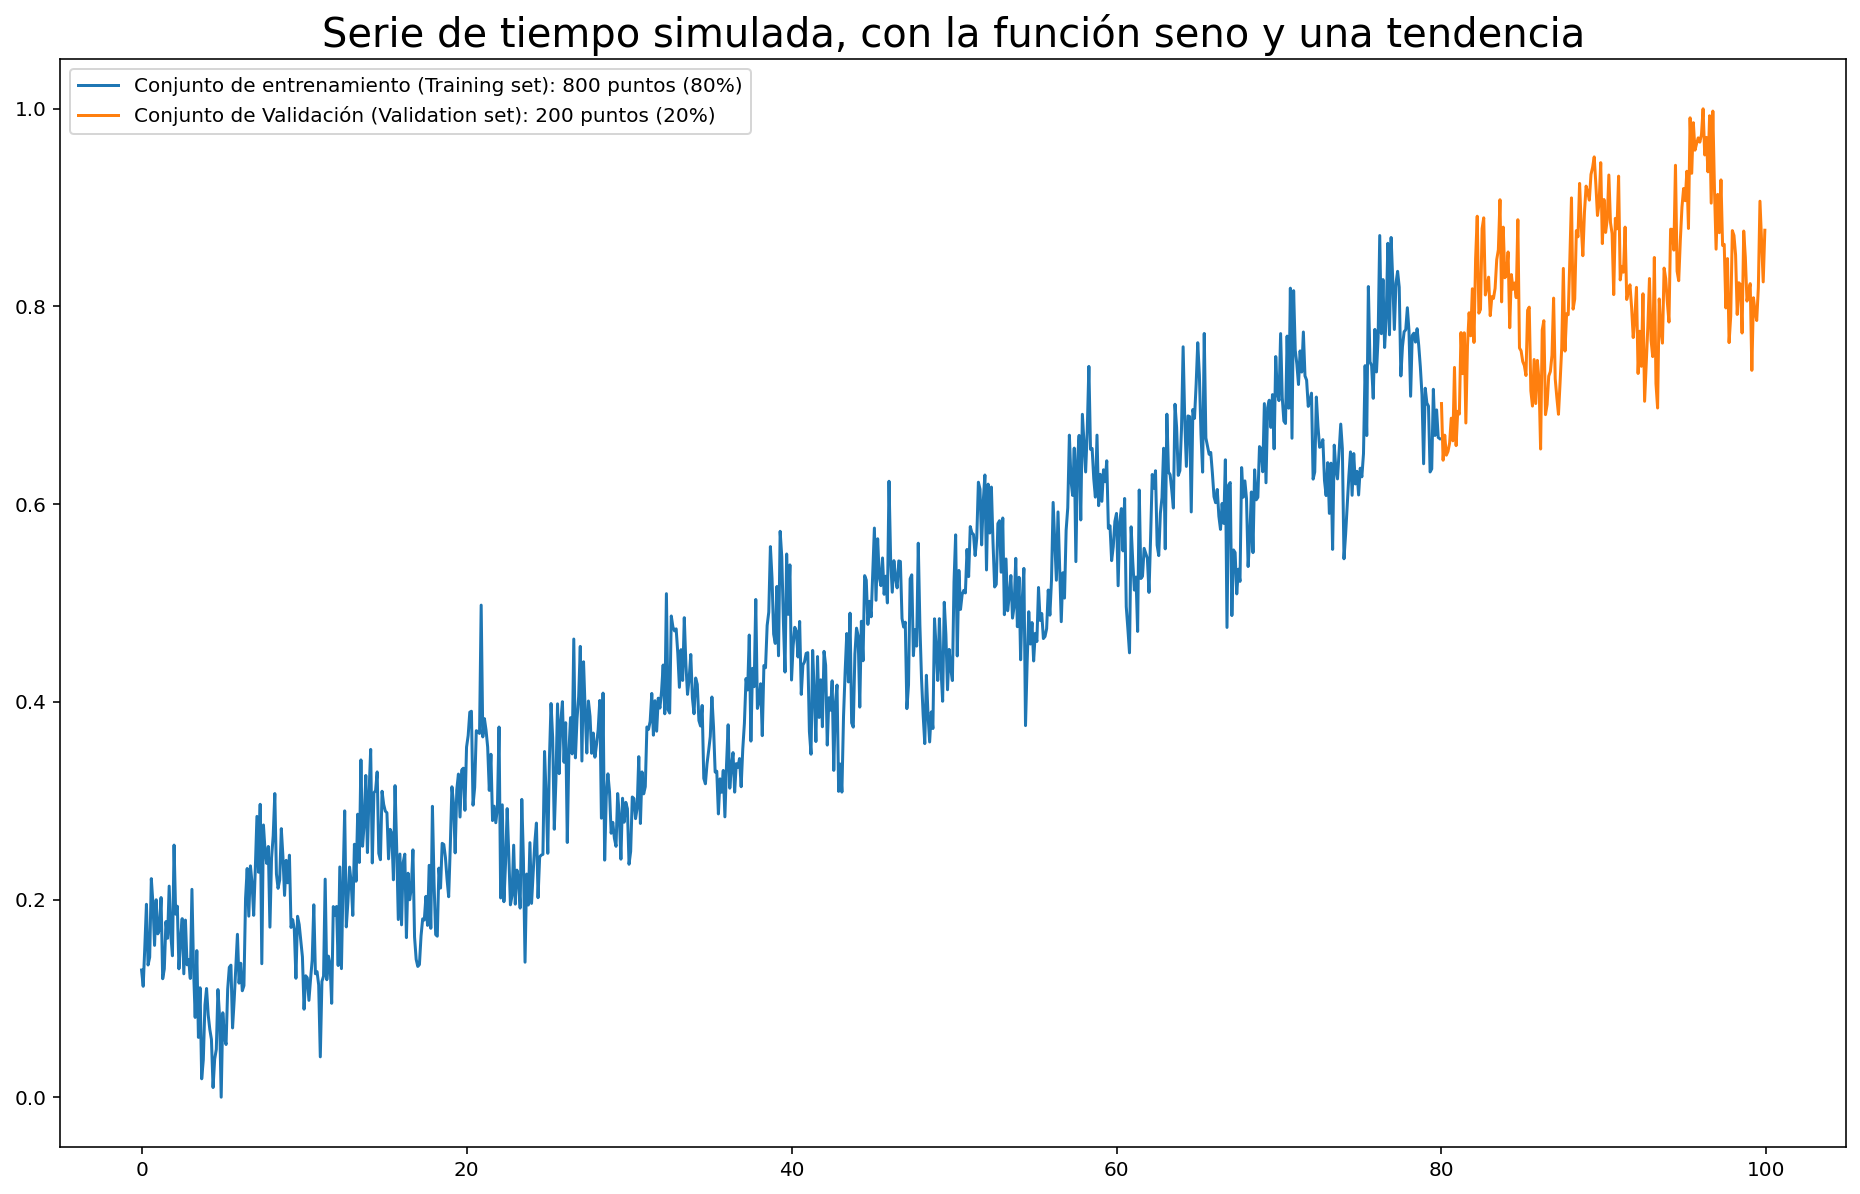

In [ ]:
plt.plot(train, label='Conjunto de entrenamiento (Training set): ' + str(len_train) +' puntos (80%)')
plt.plot(test, label='Conjunto de Validación (Validation set): '  + str(len_test) + ' puntos (20%)') 
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend()
plt.show()

Preparar los datos para la predicción de valores y definimos cuantos datos usar para predecir el siguiente, en este caso se usarán 50

In [ ]:
def create_dataset(X, y, time_steps=1):
    # crea dos listas vacias para depositar los datos
    Xs, ys = [], []
    # usa paquetes definidos que luego se usarán en la red para predecir el siguiente. Cada paquete es para predecir un dato
    # Comienza a avanzar hacia adelante.
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Los conjuntos de datos como los pide la red LSTM

In [ ]:
time_steps = 50

# reshape to [samples, time_steps, n_features]

# dos veces para ir armando los bloques en la misma tira
X_train, y_train = create_dataset(train, train, time_steps)
X_test, y_test = create_dataset(test, test, time_steps)

# en test debemos darle entonces uno de esos bloques
print(X_train.shape, y_train.shape)

print([X_train[0:2,], y_train[0:2]])

(750, 50, 1) (750, 1)
[array([[[0.12866229],
        [0.1121937 ],
        [0.15199099],
        [0.19517542],
        [0.13373672],
        [0.14166865],
        [0.2211258 ],
        [0.19603986],
        [0.15358548],
        [0.19974127],
        [0.16525499],
        [0.16990083],
        [0.20199465],
        [0.11982438],
        [0.12982285],
        [0.17767362],
        [0.16076588],
        [0.21355511],
        [0.16446774],
        [0.14307962],
        [0.25505916],
        [0.1851261 ],
        [0.19321062],
        [0.12984983],
        [0.15998183],
        [0.18065415],
        [0.12482759],
        [0.17917075],
        [0.13392128],
        [0.13937234],
        [0.12008995],
        [0.21029807],
        [0.12917938],
        [0.0806848 ],
        [0.14828083],
        [0.0604929 ],
        [0.11070353],
        [0.01858177],
        [0.03791053],
        [0.09315708],
        [0.10995165],
        [0.08338189],
        [0.06856677],
        [0.05846956],
        [

## Modelo LSTM

### Creamos el modelo

In [ ]:
# shapes
inputs_shape = (X_train.shape[1], X_train.shape[2]) #filas de tamaño 50, unidimensionales
lstm_output = 60

# layers
inputs = Input(inputs_shape)
x = LSTM(units=lstm_output, name='LSTM_layer')(inputs) #novedad
outputs = Dense(1)(x) #y_est

# model
serie_0_1_model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')

Número de neuronas

In [ ]:
lstm_output =60
input_size =1 # input size in the LSTM machine
#
# cada entrada de tamaño 50 es mostrada a la máquina  LSTM machine uno por uno.
# luego se tiene
#
num_params = 4*(lstm_output*lstm_output + lstm_output*input_size+ lstm_output)
num_params

14880

Compila

In [ ]:
serie_0_1_model.compile(loss='mean_squared_error',
  optimizer=Adam(0.001)
)

### Entrenamiento

In [ ]:
history = serie_0_1_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16, #lotes de 16 arreglos (50,1)
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/30
43/43 [==============================] - 4s 42ms/step - loss: 0.0130 - val_loss: 0.0032
Epoch 2/30
43/43 [==============================] - 1s 20ms/step - loss: 0.0081 - val_loss: 0.0030
Epoch 3/30
43/43 [==============================] - 1s 20ms/step - loss: 0.0063 - val_loss: 0.0024
Epoch 4/30
43/43 [==============================] - 1s 21ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 5/30
43/43 [==============================] - 1s 21ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 6/30
43/43 [==============================] - 1s 21ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 7/30
43/43 [==============================] - 1s 20ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 8/30
43/43 [==============================] - 1s 21ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 9/30
43/43 [==============================] - 1s 20ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 10/30
43/43 [==============================] - 1s 20ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 11/

### Evaluación del modelo

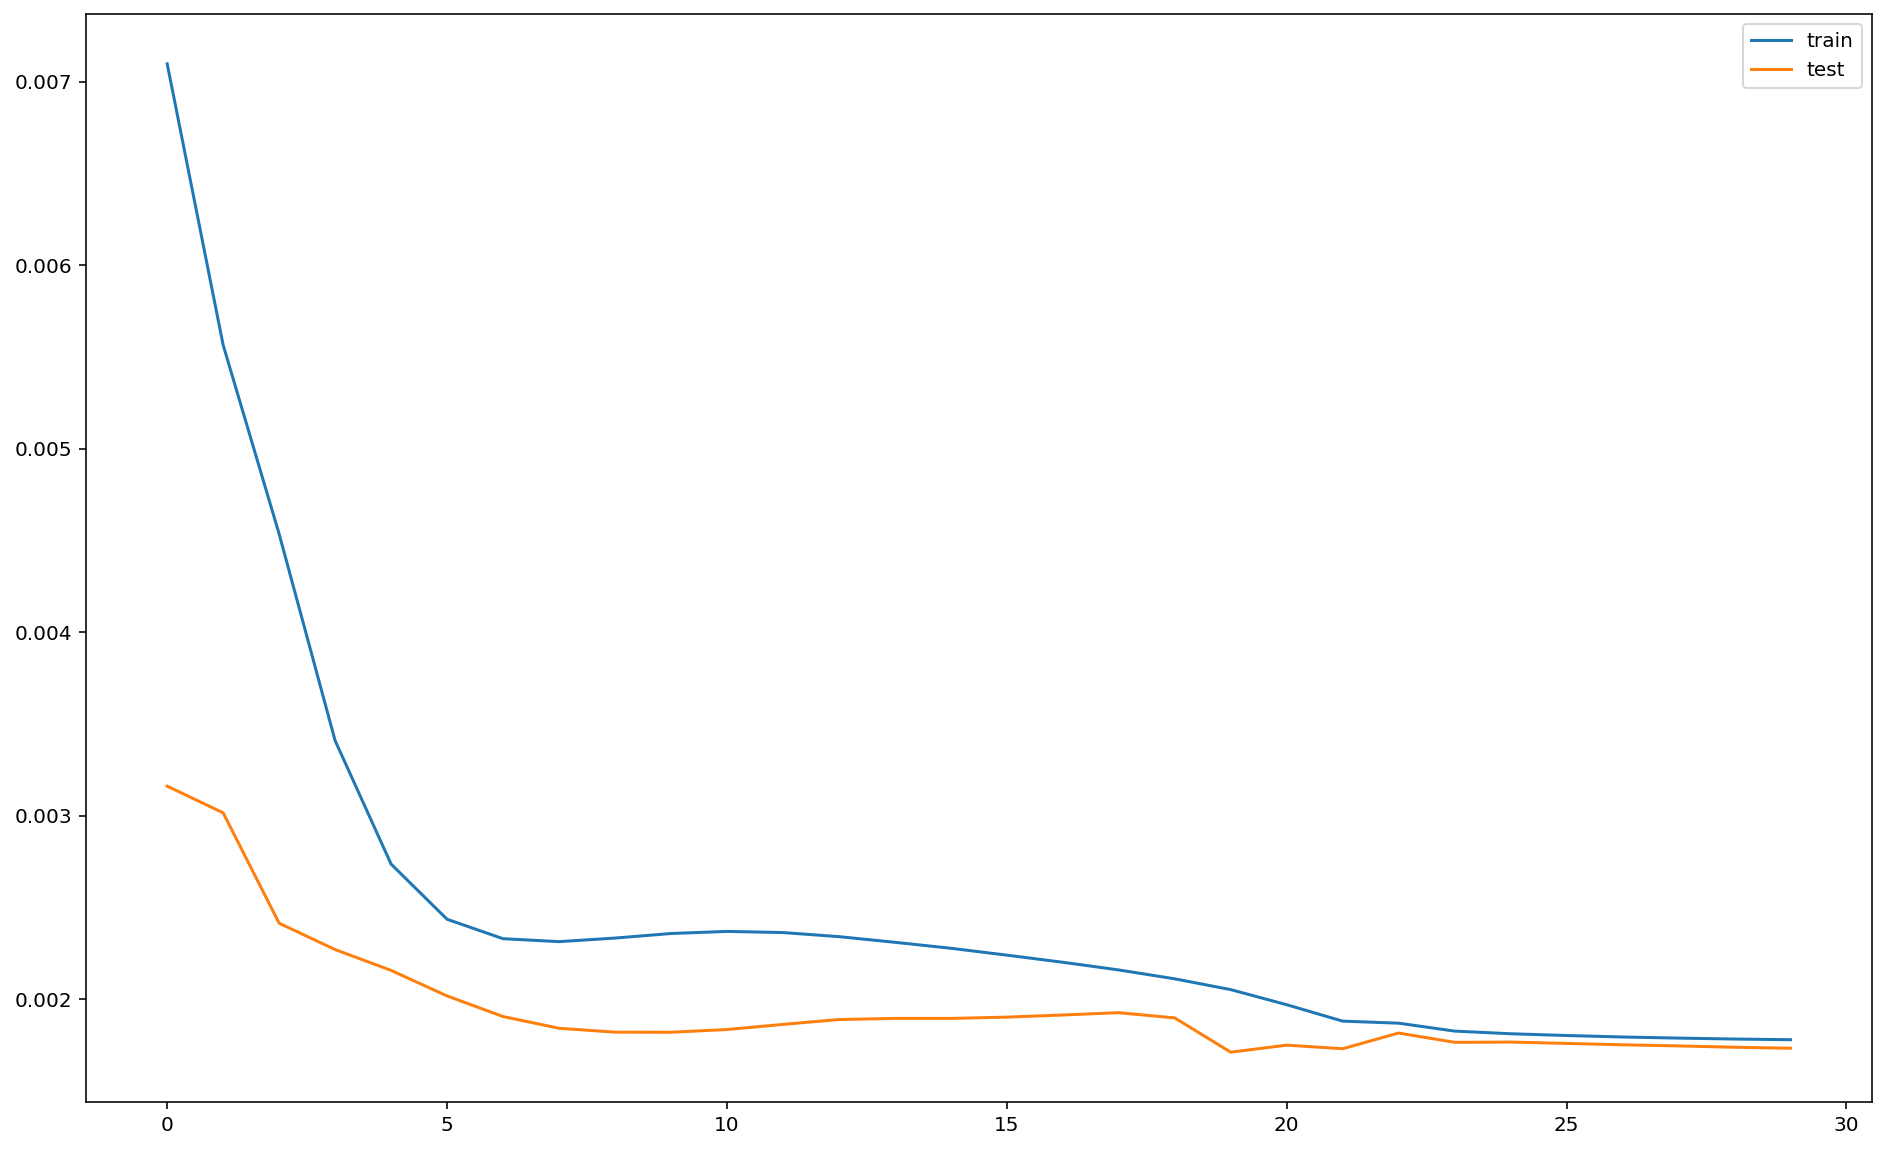

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

y_pred =serie_0_1_model.predict(X_test) #predecimos con X_test que es un tensor (150,50,1)

Grafico de los valores predecidos y reales

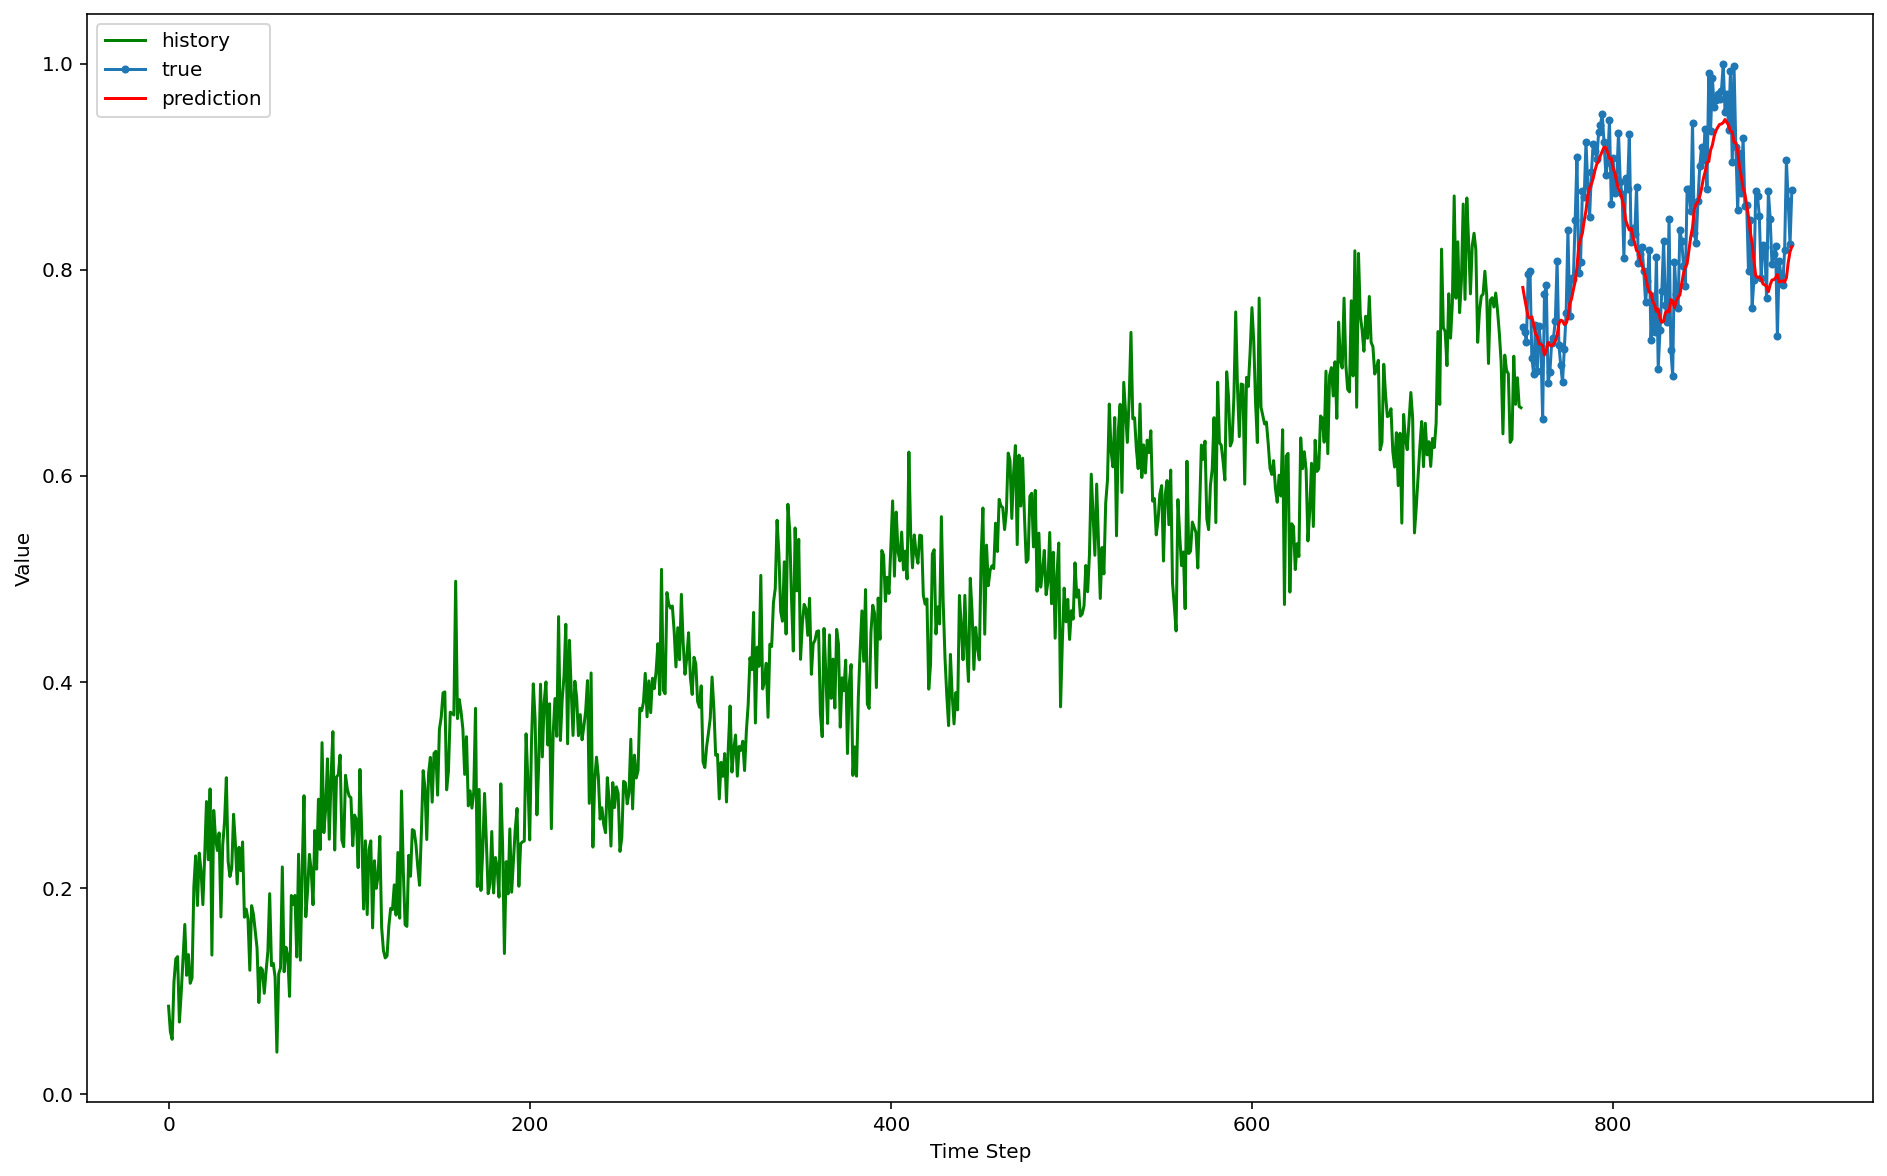

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

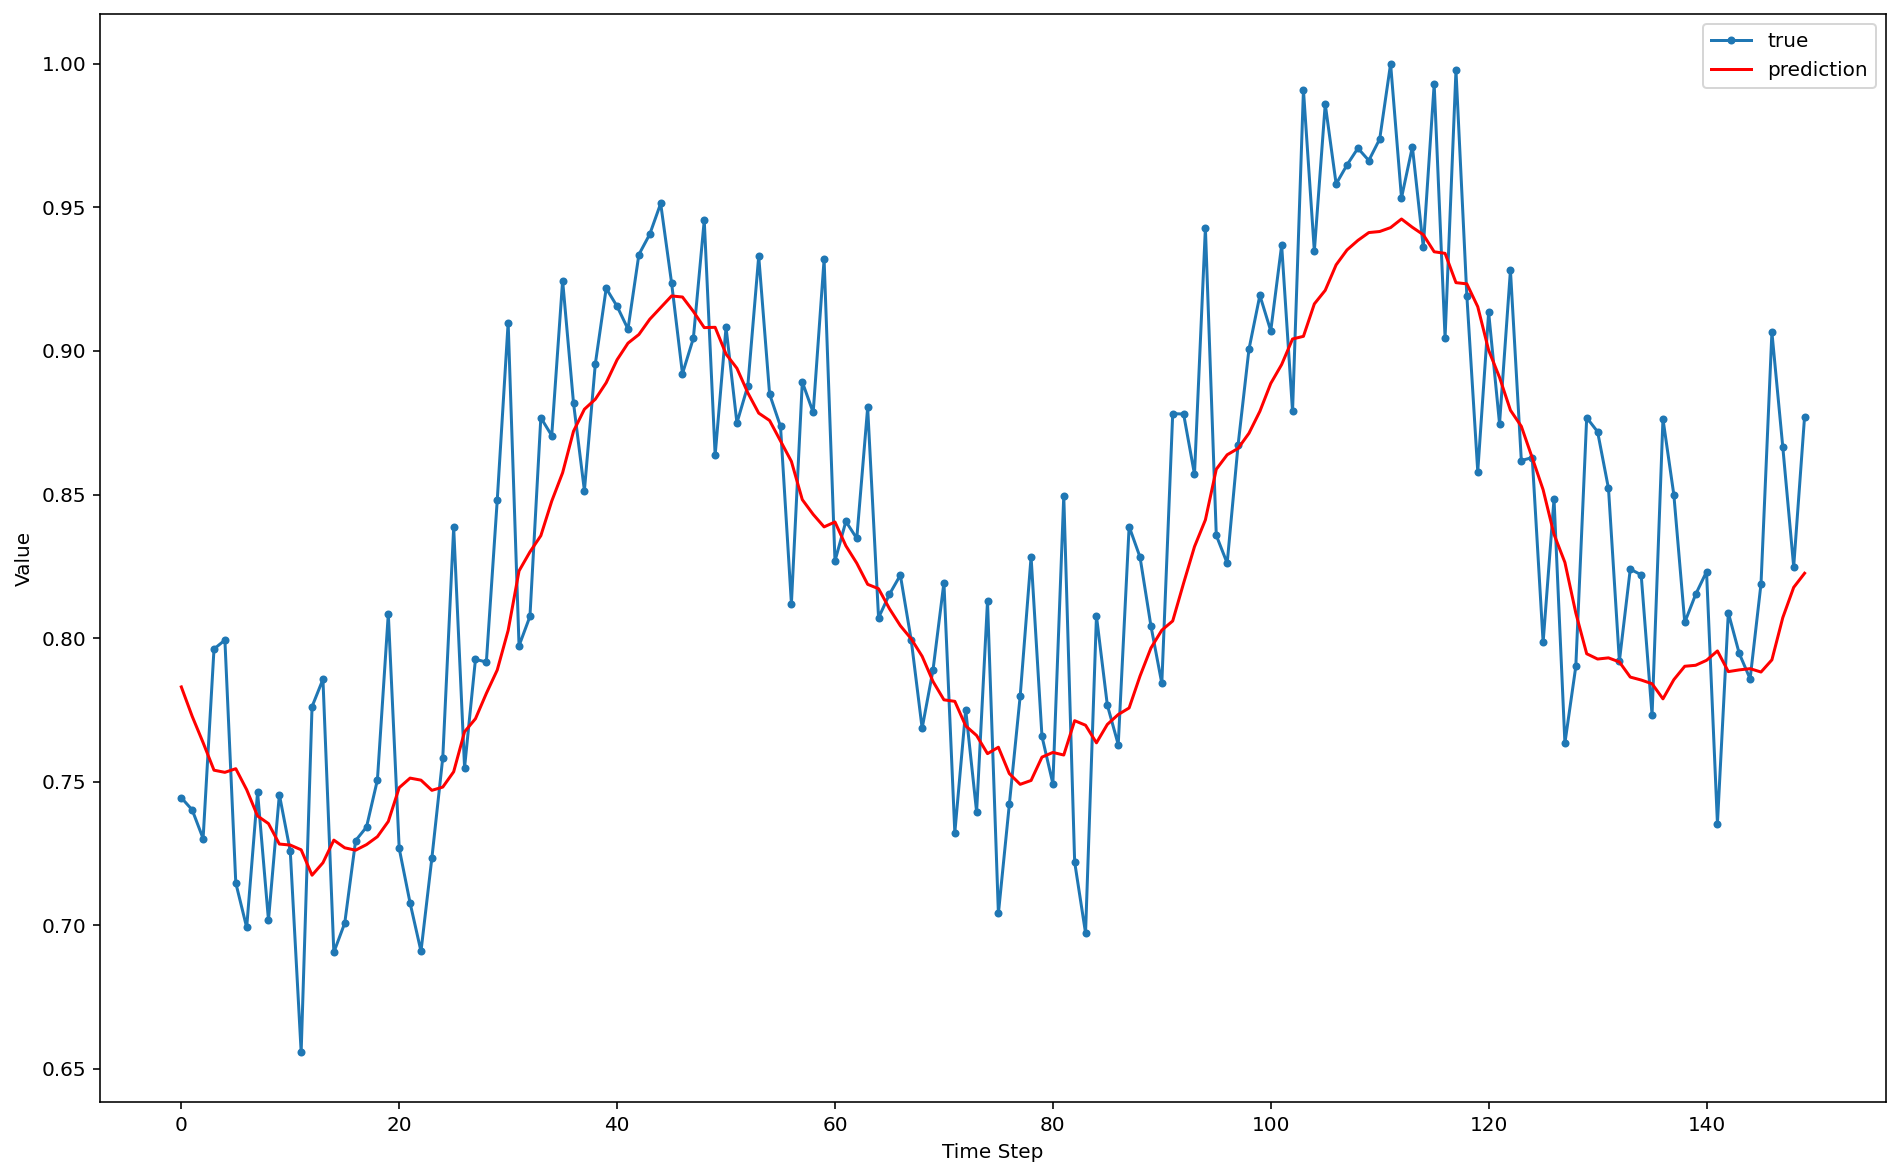

In [ ]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
mse_testLS = serie_0_1_model.evaluate(X_test,y_test)

5/5 [==============================] - 0s 8ms/step - loss: 0.0018


### Transformamos a la escala original

In [ ]:
scaled_data = scaler.fit_transform(df1.values)
dataset = pd.DataFrame(scaled_data)
dataset.columns = ['sine']
dataset.index = df1.index
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
y_test.shape

(150, 1)

Vemos su grafico

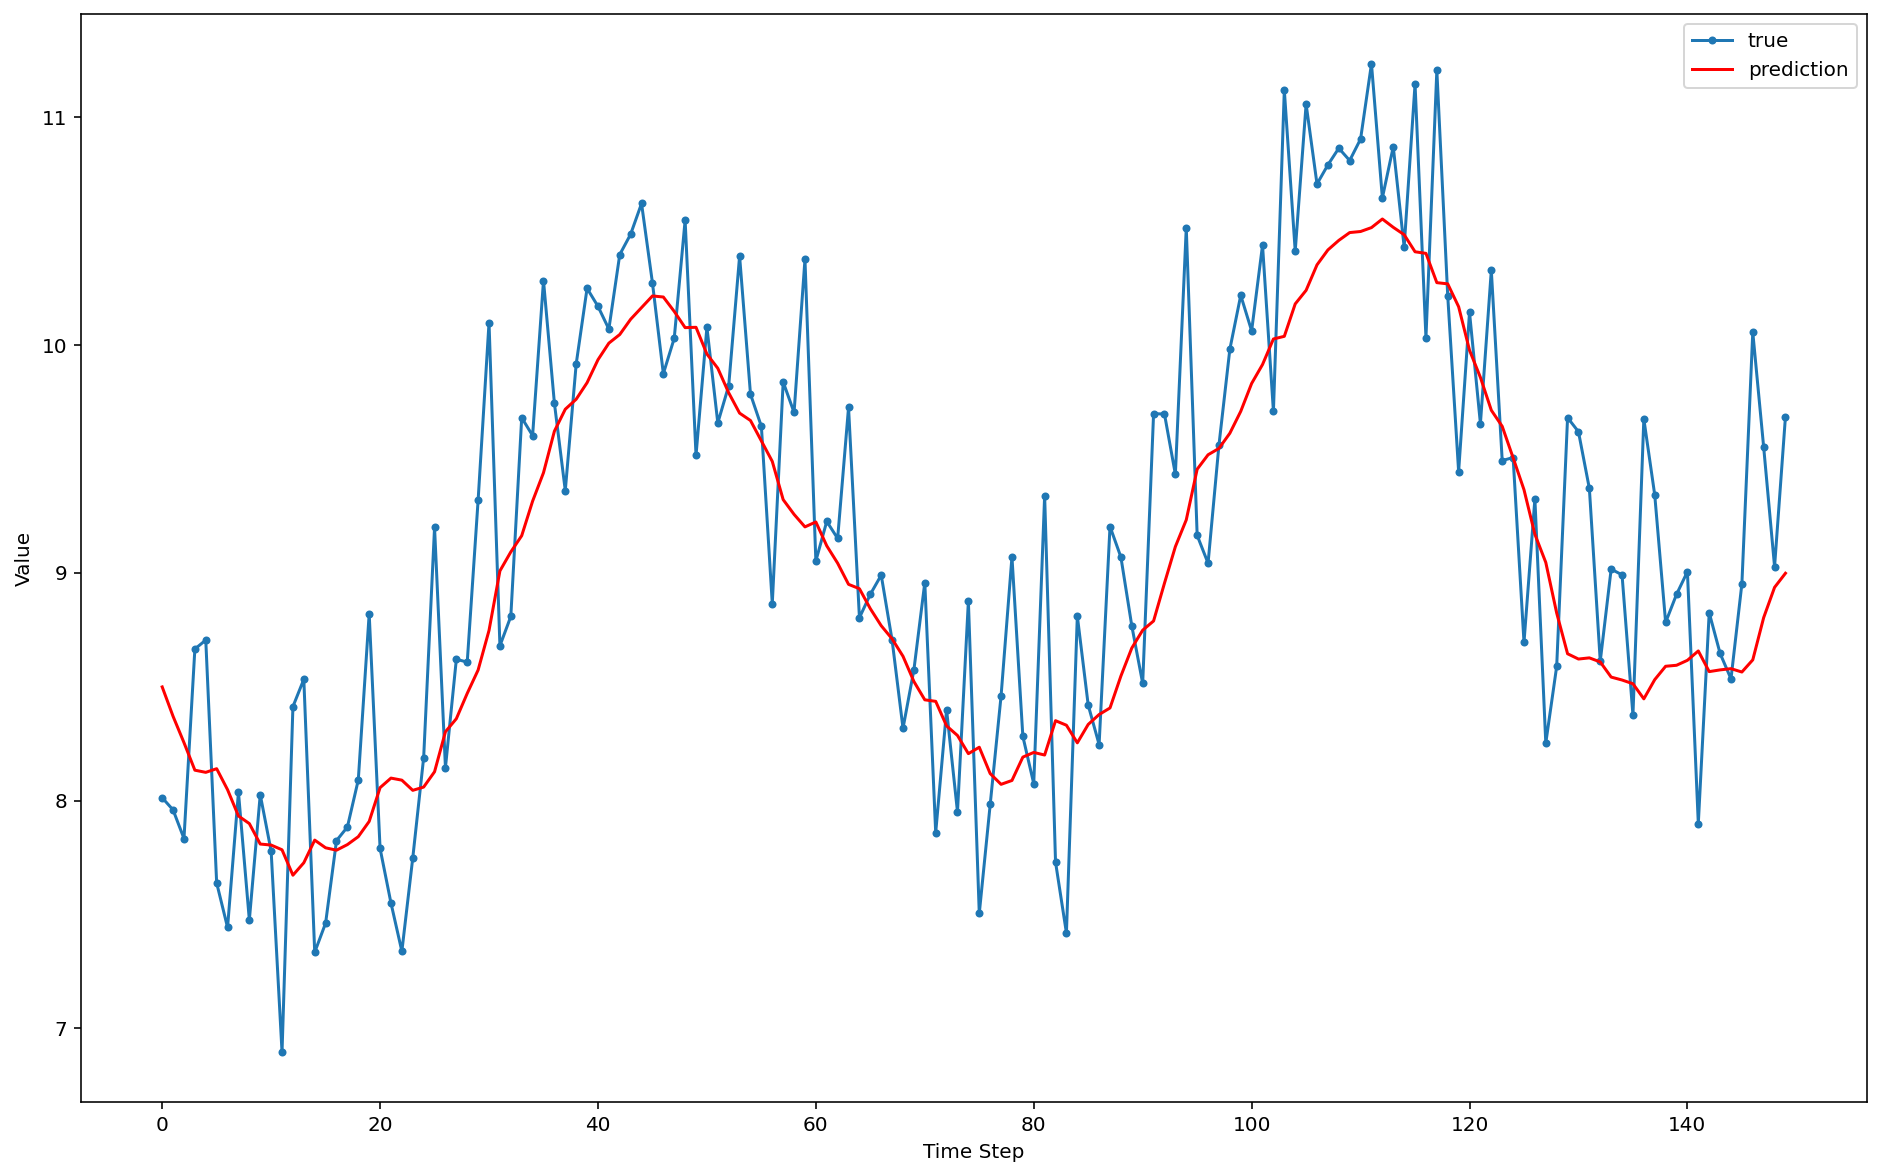

In [ ]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## Modelo de Redes Neuronales 

In [ ]:
ts =pd.Series(sin,index=pd.date_range('1/1/2000', periods=1000))
#SerieInt
type(ts)
print(ts)


2000-01-01     0.248357
2000-01-02     0.040701
2000-01-03     0.542514
2000-01-04     1.087035
2000-01-05     0.312342
                ...    
2002-09-22     8.951655
2002-09-23    10.056647
2002-09-24     9.551839
2002-09-25     9.026822
2002-09-26     9.686367
Freq: D, Length: 1000, dtype: float64


In [ ]:
from pandas import DataFrame
# reframe as supervised learning
# lag observation (t-1) is the input variable and t is the output variable.
df1 = DataFrame()
print(df1)


Empty DataFrame
Columns: []
Index: []


In [ ]:
df = pd.DataFrame(ts.values,index=ts.index)
type(df)
print(df)


                    0
2000-01-01   0.248357
2000-01-02   0.040701
2000-01-03   0.542514
2000-01-04   1.087035
2000-01-05   0.312342
...               ...
2002-09-22   8.951655
2002-09-23  10.056647
2002-09-24   9.551839
2002-09-25   9.026822
2002-09-26   9.686367

[1000 rows x 1 columns]


In [ ]:
for i in range(10,0,-1):
    df1[['t-'+str(i)]] = df.shift(i)
    
print(df1)


                t-10       t-9       t-8  ...        t-3        t-2        t-1
2000-01-01       NaN       NaN       NaN  ...        NaN        NaN        NaN
2000-01-02       NaN       NaN       NaN  ...        NaN        NaN   0.248357
2000-01-03       NaN       NaN       NaN  ...        NaN   0.248357   0.040701
2000-01-04       NaN       NaN       NaN  ...   0.248357   0.040701   0.542514
2000-01-05       NaN       NaN       NaN  ...   0.040701   0.542514   1.087035
...              ...       ...       ...  ...        ...        ...        ...
2002-09-22  8.374840  9.675862  9.342335  ...   8.825033   8.646197   8.534367
2002-09-23  9.675862  9.342335  8.782318  ...   8.646197   8.534367   8.951655
2002-09-24  9.342335  8.782318  8.905253  ...   8.534367   8.951655  10.056647
2002-09-25  8.782318  8.905253  9.004985  ...   8.951655  10.056647   9.551839
2002-09-26  8.905253  9.004985  7.898893  ...  10.056647   9.551839   9.026822

[1000 rows x 10 columns]


In [ ]:
df1['t'] = df.values
print(df1)


                t-10       t-9       t-8  ...        t-2        t-1          t
2000-01-01       NaN       NaN       NaN  ...        NaN        NaN   0.248357
2000-01-02       NaN       NaN       NaN  ...        NaN   0.248357   0.040701
2000-01-03       NaN       NaN       NaN  ...   0.248357   0.040701   0.542514
2000-01-04       NaN       NaN       NaN  ...   0.040701   0.542514   1.087035
2000-01-05       NaN       NaN       NaN  ...   0.542514   1.087035   0.312342
...              ...       ...       ...  ...        ...        ...        ...
2002-09-22  8.374840  9.675862  9.342335  ...   8.646197   8.534367   8.951655
2002-09-23  9.675862  9.342335  8.782318  ...   8.534367   8.951655  10.056647
2002-09-24  9.342335  8.782318  8.905253  ...   8.951655  10.056647   9.551839
2002-09-25  8.782318  8.905253  9.004985  ...  10.056647   9.551839   9.026822
2002-09-26  8.905253  9.004985  7.898893  ...   9.551839   9.026822   9.686367

[1000 rows x 11 columns]


In [ ]:
df1_ENE = df1[10:]
print(df1_ENE)
df1_ENE.size


                t-10       t-9       t-8  ...        t-2        t-1          t
2000-01-11  0.248357  0.040701  0.542514  ...   0.562619   1.144607   0.709762
2000-01-12  0.040701  0.542514  1.087035  ...   1.144607   0.709762   0.768342
2000-01-13  0.542514  1.087035  0.312342  ...   0.709762   0.768342   1.173020
2000-01-14  1.087035  0.312342  0.412357  ...   0.768342   1.173020   0.136918
2000-01-15  0.312342  0.412357  1.414249  ...   1.173020   0.136918   0.262991
...              ...       ...       ...  ...        ...        ...        ...
2002-09-22  8.374840  9.675862  9.342335  ...   8.646197   8.534367   8.951655
2002-09-23  9.675862  9.342335  8.782318  ...   8.534367   8.951655  10.056647
2002-09-24  9.342335  8.782318  8.905253  ...   8.951655  10.056647   9.551839
2002-09-25  8.782318  8.905253  9.004985  ...  10.056647   9.551839   9.026822
2002-09-26  8.905253  9.004985  7.898893  ...   9.551839   9.026822   9.686367

[990 rows x 11 columns]


10890

In [ ]:
ENEsplit = df1_ENE.values
# split into lagged variables and original time series
X1= ENEsplit[:, 0:-1] # slice all rows and start with column 0 and go up to but not including the last column
y1 =ENEsplit[:,-1] # slice all rows and last column, essentially separating out 't' column


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train, X_test, y_train, y_test=train_test_split(X1,y1,test_size=0.2, train_size=0.8, shuffle=False)


In [ ]:
import tensorflow.keras as keras

model=keras.models.Sequential([keras.layers.Dense(8,activation="relu",input_shape=X_train.shape[1:]),keras.layers.Dense(1)])
#primera capa oculta con 32 unidades, fun. relu y dimensión de entrada    
#capa de salida con una de salida
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

In [ ]:
model.compile(loss="mean_squared_error",optimizer="adam")
history=model.fit(X_train,y_train,epochs=30,validation_split=0.1, verbose=1, shuffle=False)


Epoch 1/30
23/23 [==============================] - 0s 8ms/step - loss: 37.5447 - val_loss: 231.1463
Epoch 2/30
23/23 [==============================] - 0s 3ms/step - loss: 24.4263 - val_loss: 153.3033
Epoch 3/30
23/23 [==============================] - 0s 3ms/step - loss: 14.8272 - val_loss: 84.1979
Epoch 4/30
23/23 [==============================] - 0s 3ms/step - loss: 7.4285 - val_loss: 39.6472
Epoch 5/30
23/23 [==============================] - 0s 3ms/step - loss: 3.2843 - val_loss: 16.1138
Epoch 6/30
23/23 [==============================] - 0s 3ms/step - loss: 1.3516 - val_loss: 5.6469
Epoch 7/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6408 - val_loss: 1.8629
Epoch 8/30
23/23 [==============================] - 0s 3ms/step - loss: 0.4565 - val_loss: 0.7670
Epoch 9/30
23/23 [==============================] - 0s 3ms/step - loss: 0.4333 - val_loss: 0.5020
Epoch 10/30
23/23 [==============================] - 0s 3ms/step - loss: 0.4380 - val_loss: 0.4421
Epoch 11/

### Evaluación del modelo

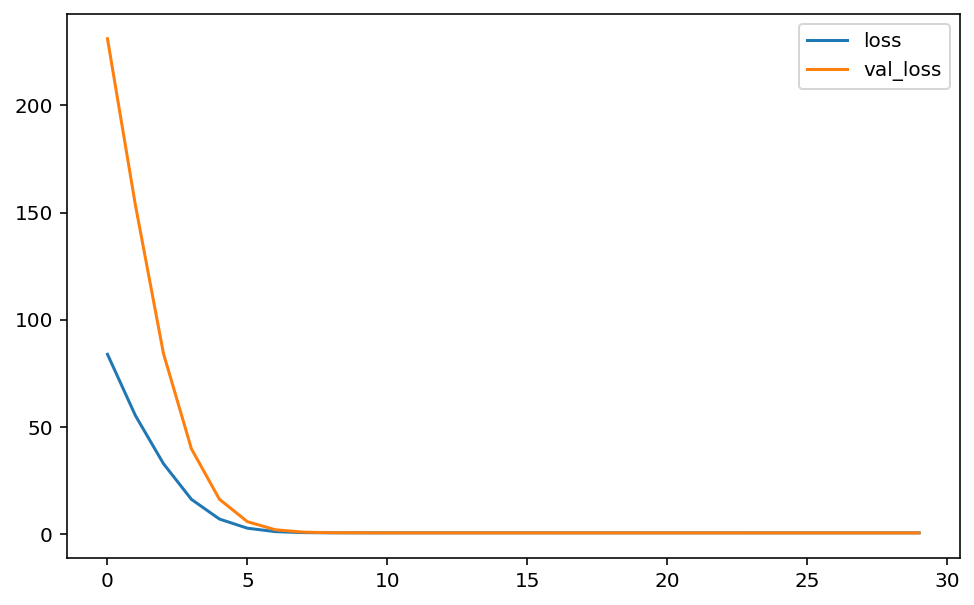

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))


In [ ]:
mse_test=model.evaluate(X_test,y_test)


7/7 [==============================] - 0s 2ms/step - loss: 0.4874


In [ ]:
ypred=model.predict(X_test)


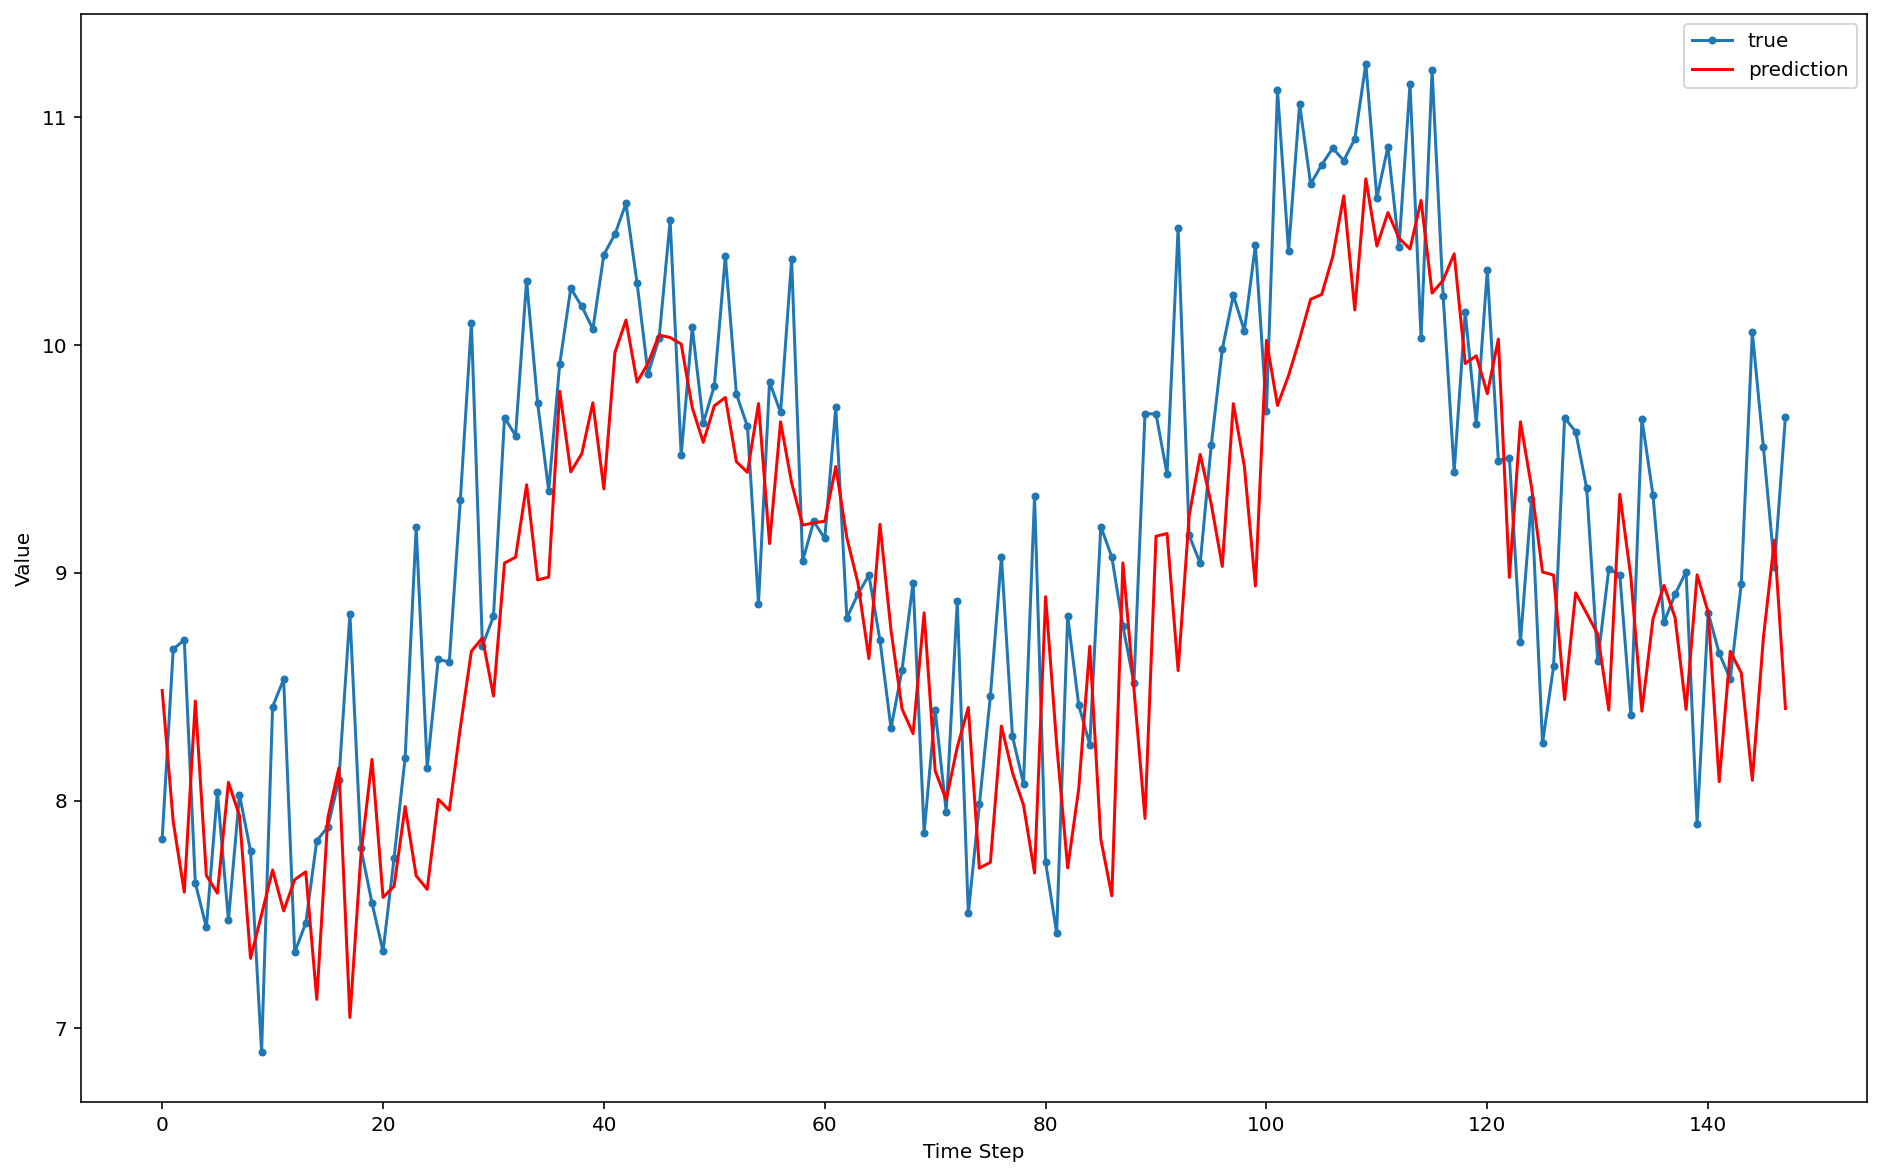

In [ ]:

plt.plot(y_test[50:200], marker='.', label="true")
plt.plot(ypred[50:200], 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Ejemplo con datos reales - predicción del Dogecoin

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from tensorflow.keras.layers import Input, LSTM, Dense, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import Sequential

Importamos la base de datos necesaria, correspondiente al valor de la criptomoneda Dogecoin desde el 17 de Septiembre de 2014 hasta el 4 de Mayo de 2021.
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_excel("/content/DOGE-USD.xlsx")
data.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,293.0,299.0,260.0,268.0,268.0,1463600.0
1,2014-09-18,268.0,325.0,267.0,298.0,298.0,2215910.0
2,2014-09-19,298.0,307.0,275.0,277.0,277.0,883563.0
3,2014-09-20,276.0,310.0,267.0,292.0,292.0,993004.0
4,2014-09-21,293.0,299.0,284.0,288.0,288.0,539140.0
5,2014-09-22,288.0,301.0,285.0,298.0,298.0,620222.0
6,2014-09-23,298.0,318.0,295.0,313.0,313.0,739197.0
7,2014-09-24,314.0,353.0,310.0,348.0,348.0,1277840.0
8,2014-09-25,347.0,383.0,332.0,375.0,375.0,2393610.0
9,2014-09-26,374.0,467.0,373.0,451.0,451.0,4722610.0


In [ ]:
#Observamos el tipo de elemento
type(data)

pandas.core.frame.DataFrame

Observamos si hay existencia de valores faltantes en la base de datos

In [ ]:
data.isna().sum()

Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

Eliminamos estos datos faltantes.

In [ ]:
data=data.dropna()

Veamos en un gráfico el comportamiento de las variables que componenen la base de datos

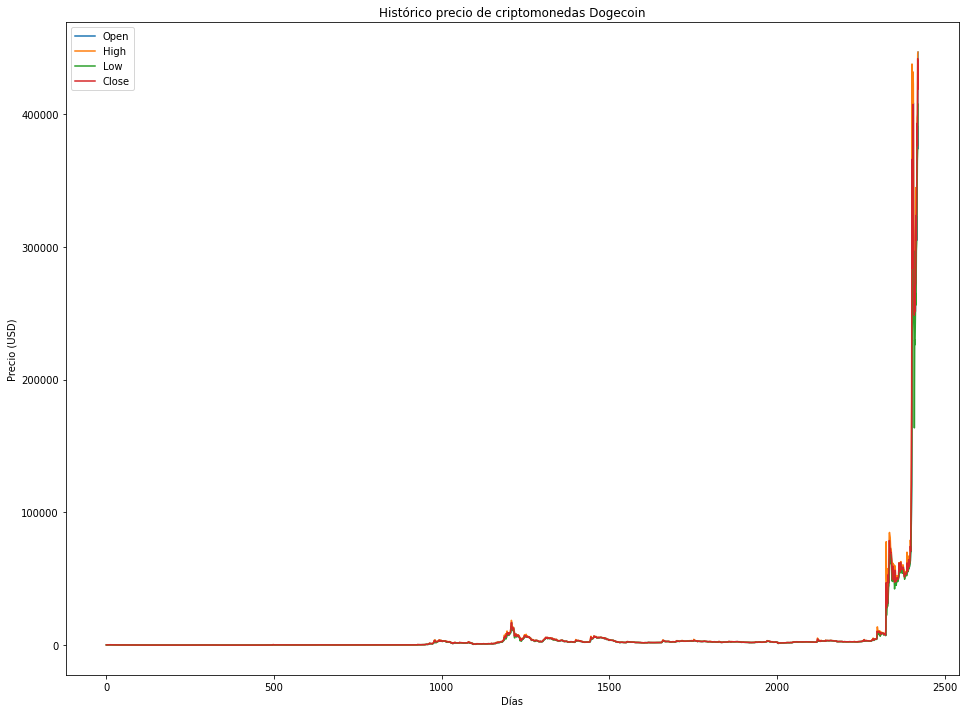

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(data["Open"])
plt.plot(data["High"])
plt.plot(data["Low"])
plt.plot(data["Close"])
plt.title('Histórico precio de criptomonedas Dogecoin')
plt.ylabel('Precio (USD)')
plt.xlabel('Días')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

Convertimos nuestro objeto en una serie de tiempo

In [ ]:
data['Date']=pd.to_datetime(data['Date'])
df=data.set_index('Date')
ts=df['Open']
ts.frecuency='D'
print(type(ts))

<class 'pandas.core.series.Series'>


Obtenemos una gráfica de la serie de tiempo, con la variable e interés; "Open"

Text(0.5, 0, 'Días')

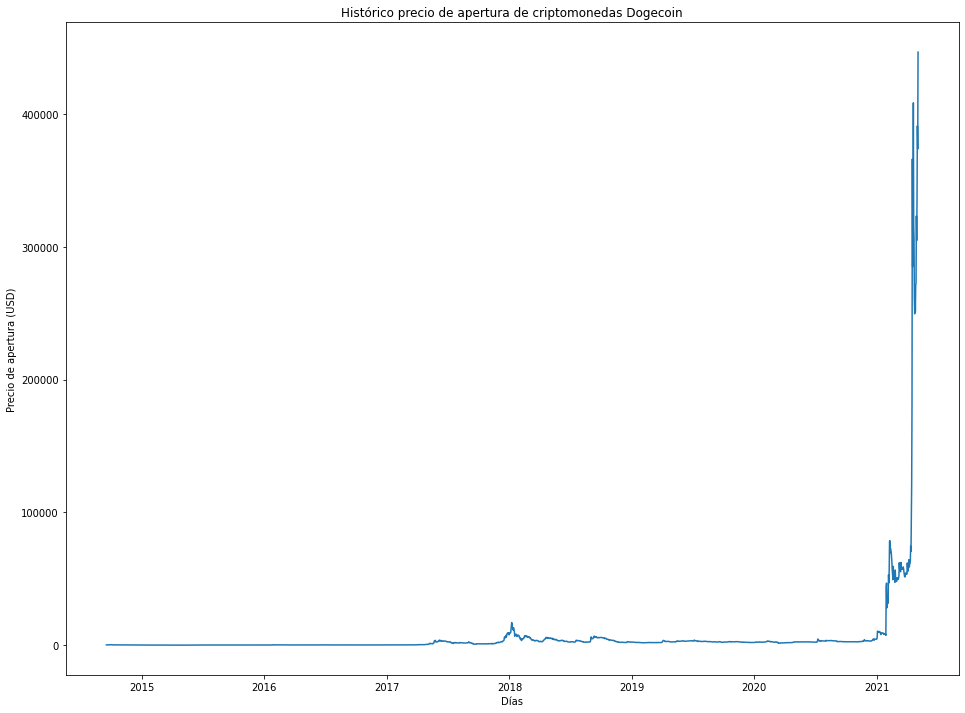

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(ts)
plt.title('Histórico precio de apertura de criptomonedas Dogecoin')
plt.ylabel('Precio de apertura (USD)')
plt.xlabel('Días')

Observamos el gráfico de autocorrelación para 100 rezagos y así tomar la decisión sobre el número de covariables a utilizar. 

<Figure size 720x576 with 0 Axes>

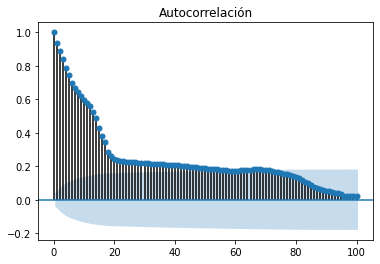

In [ ]:
plt.figure(figsize=(10,8))
plot_acf(ts, lags=100, title='Autocorrelación')
plt.show()

Se puede ver en la grafica de autocorrelación que existe una alta correlación en los primeros 40 rezagos, por lo que se decide tomar estos como autocovariables.


**Escalamiento de los datos** 

Por regla general al trabajar con redes neuronales se deben normalizar o escalar los datos, en este caso utilizaremos el comando MinMaxScaler del paquete sklearn para escalar los datos entre 0 y 1.

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
ts_scaled = scaler.fit_transform(data.iloc[:,1:2])

**Creación de las variables rezagadas**

El objetivo de la red  es poder predecir el valor de la acción de apertura de Dogecpin en el tiempo T basandonos en los datos de los días T-N para cualquier número de pasos N. Para nuestro caso se ha decidido utilizar N=40.
Lo que haremos es crear dos listas (features_set y labels). Para ello creamos un ciclo que comienza desde el registro 41 y almacena los 60 registros previos en features_set y el registro 41 en la lista "labels".

In [ ]:
features_set = []
labels = []
for i in range(40, len(data)):
    features_set.append(ts_scaled[i-40:i, 0])
    labels.append(ts_scaled[i, 0])

Para poder usar dichos datos para nuestro entrenamientro es necesario convertir nuestra lista como una matriz numpy con el siguiente código:

In [ ]:
features_set, labels = np.array(features_set), np.array(labels)

**División del conjunto de datos en datos de entrenamiento y datos de validación**

Se decide dividir el conjunto en 90% para los datos de entrenamiento y el 10% de validación.

In [ ]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test=train_test_split(features_set,labels,test_size=0.1, train_size=0.9,shuffle=False)

Podemos observar que los conjuntos quedan con las siguientes dimensiones:

In [ ]:
print(features_train.shape)
print(features_test.shape)

print(labels_train.shape)
print(labels_test.shape)

(2140, 40)
(238, 40)
(2140,)
(238,)


**Cambio de forma de los datos como input de la red**

Por último, para moder entrenar nuestros datos, será necesario expresar nuestra matriz en formato de tres dimensiones ya que este es el formato aceptado por las redes.
*   Primera dimensión: Número de filas o registros de nuestra base de entrenamiento (2140 en nuestro caso)
*   Segunda dimensión: Número de pasos de tiempo previos (40) 
*   Tercera dimensión: Número de features, como sólo estamos trabajando **Open** nuestro indicador es 1

*   Elemento de la lista
*   Elemento de la lista



In [ ]:
features_train = np.reshape(features_train, (features_train.shape[0], features_train.shape[1], 1))
features_train.shape

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_train.shape[1], 1)))

In [ ]:
import tensorflow as tf
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.Dense(32, input_shape=[None, 1]),
    keras.layers.Dense(32, input_shape=[None, 1]),
    keras.layers.Dense(1, activation='softmax')
])
model.compile(loss="mse", optimizer='adam')

In [ ]:
model.compile(loss="mse",optimizer="adam")
history=model.fit(features_train, labels_train, epochs = 100, batch_size = 32,validation_split=0.1)

Epoch 1/100
61/61 [==============================] - 15s 122ms/step - loss: 8.0163e-05 - val_loss: 6.1713e-06
Epoch 2/100
61/61 [==============================] - 6s 93ms/step - loss: 1.0927e-05 - val_loss: 8.9534e-07
Epoch 3/100
61/61 [==============================] - 6s 94ms/step - loss: 4.9289e-06 - val_loss: 7.6774e-07
Epoch 4/100
61/61 [==============================] - 6s 95ms/step - loss: 4.2291e-06 - val_loss: 4.6924e-06
Epoch 5/100
61/61 [==============================] - 6s 95ms/step - loss: 4.6350e-06 - val_loss: 8.5337e-07
Epoch 6/100
61/61 [==============================] - 6s 96ms/step - loss: 2.5506e-06 - val_loss: 6.6311e-07
Epoch 7/100
61/61 [==============================] - 6s 96ms/step - loss: 2.5992e-06 - val_loss: 1.6414e-06
Epoch 8/100
61/61 [==============================] - 6s 96ms/step - loss: 3.3917e-06 - val_loss: 7.7436e-07
Epoch 9/100
61/61 [==============================] - 6s 96ms/step - loss: 3.1083e-06 - val_loss: 8.5960e-07
Epoch 10/100
61/61 [======

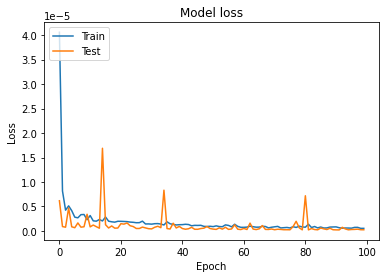

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_inputs =ts_scaled[len(ts_scaled) - len(features_test) - 40:]
test_features = []
for i in range(40,278):
    test_features.append(test_inputs[i-40:i, 0])
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
predictions = model.predict(test_features)
predictions.shape

(238, 1)

In [ ]:
test_inputs =ts_scaled[len(ts_scaled) - len(features_test) - 40:]
test_features = []
for i in range(40,278):
    test_features.append(test_inputs[i-40:i, 0])
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)
data2=data.dropna().iloc[:,1:2]
label_test1=data2[2184:2422]  

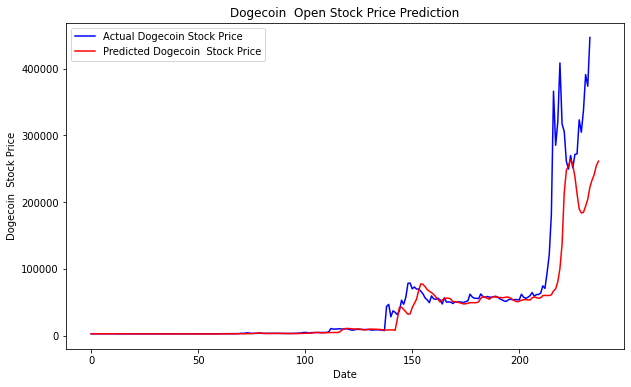

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(label_test1.values, color='blue', label='Actual Dogecoin Stock Price')
plt.plot(predictions , color='red', label='Predicted Dogecoin  Stock Price')
plt.title('Dogecoin  Open Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Dogecoin  Stock Price')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Dense, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import pandas as pd

In [ ]:
import tensorflow as tf
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)

In [ ]:
history=model.fit(features_train, labels_train, epochs = 100, batch_size = 16,validation_split=0.1)

Epoch 1/100
121/121 [==============================] - 2s 8ms/step - loss: 3.0212e-05 - val_loss: 7.5409e-06
Epoch 2/100
121/121 [==============================] - 1s 6ms/step - loss: 2.4422e-05 - val_loss: 1.4424e-05
Epoch 3/100
121/121 [==============================] - 1s 6ms/step - loss: 2.3666e-05 - val_loss: 5.6492e-06
Epoch 4/100
121/121 [==============================] - 1s 6ms/step - loss: 1.8099e-05 - val_loss: 6.1420e-06
Epoch 5/100
121/121 [==============================] - 1s 6ms/step - loss: 1.7228e-05 - val_loss: 2.9319e-06
Epoch 6/100
121/121 [==============================] - 1s 6ms/step - loss: 1.5652e-05 - val_loss: 3.3087e-06
Epoch 7/100
121/121 [==============================] - 1s 6ms/step - loss: 2.3025e-05 - val_loss: 7.9619e-06
Epoch 8/100
121/121 [==============================] - 1s 6ms/step - loss: 1.8289e-05 - val_loss: 1.0879e-05
Epoch 9/100
121/121 [==============================] - 1s 6ms/step - loss: 1.6580e-05 - val_loss: 3.7868e-06
Epoch 10/100
121/12

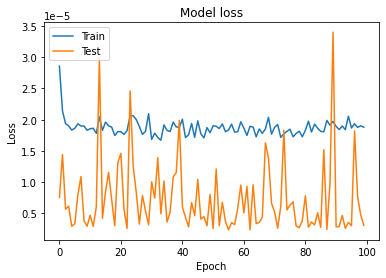

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_inputs =ts_scaled[len(ts_scaled) - len(features_test) - 40:]
test_features = []
for i in range(40,278):
    test_features.append(test_inputs[i-40:i, 0])
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)
data2=data.dropna().iloc[:,1:2]
label_test1=data2[2184:2422]  

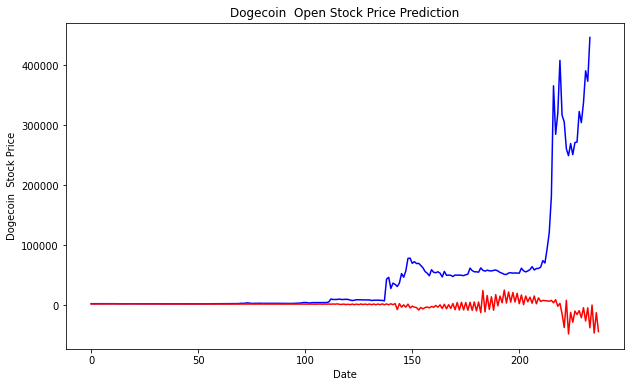

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(label_test1.values, color='blue', label='Actual Dogecoin Stock Price')
plt.plot(predictions , color='red', label='Predicted Dogecoin  Stock Price')
plt.title('Dogecoin  Open Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Dogecoin  Stock Price')
plt.show()

**Entrenando la red LSTM**

Una vez hemos adecuado nuestra base para el entrenamiento podemos proceder a la creación de nuestro modelo.
Nuestro LSTM será un modelo secuencial con cuatro capas seguido de una capa densa.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(features_train.shape[1], 1)))

*   units="Número de neuronas que deseamos en la capa"
*   return_sequences="True" si se le añadiran más capas al modelo
*   input_shape[1,]=el primer parametro es el número de pasos de tiempo N
*   input_shape[,2]=el segundo parametro es el número de indicadores

In [ ]:
model.add(LSTM(units=64, return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(units=64))
#model.add(Dropout(0.2))

**Compilación del modelo**

Antes del entrenamiento del modelo, lo compilamos.

In [ ]:
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 40, 64)            16896     
_________________________________________________________________
lstm_10 (LSTM)               (None, 40, 64)            33024     
_________________________________________________________________
lstm_11 (LSTM)               (None, 40, 64)            33024     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

En este caso usamos la funcion de perdida del cuadrado medio del error y el optimizador escogido para reducir dicha función de perdida es "adam"

**Entrenamiento del modelo**

In [ ]:
history=model.fit(features_train, labels_train, epochs = 100, batch_size = 32,validation_split=0.1)

Epoch 1/100
61/61 [==============================] - 14s 112ms/step - loss: 2.8107e-04 - val_loss: 1.4979e-05
Epoch 2/100
61/61 [==============================] - 5s 90ms/step - loss: 1.6847e-05 - val_loss: 9.1862e-07
Epoch 3/100
61/61 [==============================] - 5s 90ms/step - loss: 4.6616e-06 - val_loss: 9.9081e-07
Epoch 4/100
61/61 [==============================] - 6s 91ms/step - loss: 4.9380e-06 - val_loss: 1.0930e-06
Epoch 5/100
61/61 [==============================] - 6s 91ms/step - loss: 3.4395e-06 - val_loss: 2.4298e-06
Epoch 6/100
61/61 [==============================] - 6s 91ms/step - loss: 4.7845e-06 - val_loss: 3.7796e-06
Epoch 7/100
61/61 [==============================] - 6s 92ms/step - loss: 3.0636e-06 - val_loss: 1.2306e-06
Epoch 8/100
61/61 [==============================] - 6s 92ms/step - loss: 4.0397e-06 - val_loss: 6.0596e-07
Epoch 9/100
61/61 [==============================] - 6s 93ms/step - loss: 2.2206e-06 - val_loss: 7.9816e-07
Epoch 10/100
61/61 [======

**Función de pérdida del modelo**

Verificamos por medio de la gráfica, la función de pérdida del modelo.

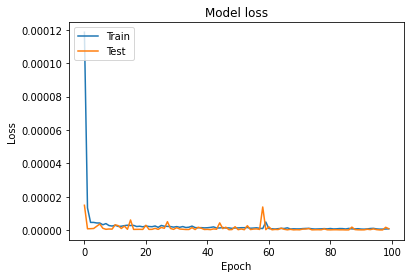

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Testeo del modelo**

Hemos entrenado exitosamente nuestro modelo, nuestro siguiente paso será observar que tan bien se ajusta a datos que no estuvieron presentes  en el entrenamiento. En nuestro caso nuestros datos de testeo serán las últimas 238 observaciones.
Como requerimos de los 60 registros previos para poder predecir en nuestro modelo, el siguiente paso es añadir nuestros 40 datos previos al primer valor de testeo.

In [ ]:
test_inputs =ts_scaled[len(ts_scaled) - len(features_test) - 40:]

In [ ]:
len(features_test)


238

In [ ]:
len(test_inputs)

278

Creamos nuestro conjunto de 60 datos para los test_feature, los convertimos en matrices y los escribimos en su formato de tercera dimensión.

In [ ]:
test_features = []
for i in range(40,278):
    test_features.append(test_inputs[i-40:i, 0])    

In [ ]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [ ]:
print(test_features)

[[[0.00687067]
  [0.00696696]
  [0.00695353]
  ...
  [0.00679676]
  [0.00607342]
  [0.0062996 ]]

 [[0.00696696]
  [0.00695353]
  [0.00703639]
  ...
  [0.00607342]
  [0.0062996 ]
  [0.0059816 ]]

 [[0.00695353]
  [0.00703639]
  [0.00702743]
  ...
  [0.0062996 ]
  [0.0059816 ]
  [0.00604654]]

 ...

 [[0.1228434 ]
  [0.11967904]
  [0.11558307]
  ...
  [0.72367066]
  [0.68217344]
  [0.75575542]]

 [[0.11967904]
  [0.11558307]
  [0.11498737]
  ...
  [0.68217344]
  [0.75575542]
  [0.87562929]]

 [[0.11558307]
  [0.11498737]
  [0.1206017 ]
  ...
  [0.75575542]
  [0.87562929]
  [0.83653726]]]


In [ ]:
predictions = model.predict(test_features)

In [ ]:
predictions = scaler.inverse_transform(predictions)

In [ ]:
len(predictions)

238

In [ ]:
data2=data.dropna().iloc[:,1:2]
label_test1=data2[2184:2422]

In [ ]:
print(label_test1.values)

[[  2792.]
 [  2805.]
 [  2802.]
 [  2819.]
 [  2776.]
 [  2799.]
 [  2831.]
 [  2824.]
 [  2814.]
 [  2796.]
 [  2794.]
 [  2778.]
 [  2625.]
 [  2656.]
 [  2564.]
 [  2644.]
 [  2708.]
 [  2708.]
 [  2701.]
 [  2658.]
 [  2680.]
 [  2644.]
 [  2614.]
 [  2585.]
 [  2605.]
 [  2646.]
 [  2625.]
 [  2610.]
 [  2598.]
 [  2654.]
 [  2667.]
 [  2634.]
 [  2650.]
 [  2595.]
 [  2603.]
 [  2581.]
 [  2595.]
 [  2590.]
 [  2600.]
 [  2627.]
 [  2649.]
 [  2647.]
 [  2645.]
 [  2653.]
 [  2679.]
 [  2677.]
 [  2595.]
 [  2581.]
 [  2598.]
 [  2576.]
 [  2582.]
 [  2517.]
 [  2528.]
 [  2533.]
 [  2617.]
 [  2760.]
 [  2671.]
 [  2711.]
 [  2670.]
 [  2753.]
 [  2769.]
 [  2779.]
 [  2821.]
 [  2773.]
 [  2775.]
 [  2908.]
 [  2936.]
 [  2909.]
 [  2911.]
 [  2984.]
 [  3507.]
 [  3329.]
 [  3645.]
 [  4200.]
 [  3727.]
 [  3250.]
 [  3275.]
 [  3405.]
 [  3448.]
 [  3551.]
 [  3335.]
 [  3375.]
 [  3429.]
 [  3297.]
 [  3397.]
 [  3388.]
 [  3343.]
 [  3179.]
 [  3158.]
 [  3105.]
 [  3079.]

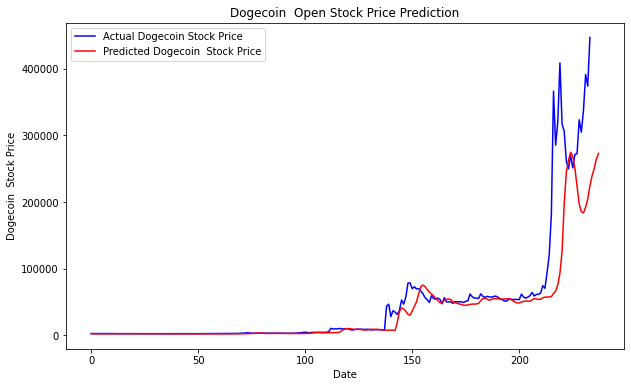

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(label_test1.values, color='blue', label='Actual Dogecoin Stock Price')
plt.plot(predictions , color='red', label='Predicted Dogecoin  Stock Price')
plt.title('Dogecoin  Open Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Dogecoin  Stock Price')
plt.legend()
plt.show()